<a href="https://colab.research.google.com/github/incerasita/ADA/blob/main/Lecture_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction and Semantic Search with Embeddings

## Prediction
We will continue with the `sms_spam.csv` dataset to analyze and predict whether an SMS is spam or not. In this instance, we will use embeddings of the text to evaluate its predictive performance.

In [1]:
import pandas as pd
import nltk

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/sms_spam.csv')
df

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will Ã¼ b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


##Sentence Embeddings
Sentence embeddings are high-dimensional vector representations of sentences, capturing the semantic properties of the text. Unlike word embeddings that represent individual words, sentence embeddings represent the entire input sentence.

###Sentence Embeddings vs. Word Embeddings

* Granularity: Word embeddings represent individual words, whereas sentence embeddings encapsulate the meaning of full sentences or even larger text chunks.
* Context Sensitivity: Word embeddings have a fixed representation for each word, regardless of its contextual use. Sentence embeddings, on the other hand, consider the context of the entire sentence, which can change the representation based on how words are used together.
* Use Cases: Word embeddings are useful for tasks like word similarity and word analogy, while sentence embeddings are better suited for tasks that require understanding of larger text units, such as document classification, sentiment analysis, and question answering.

##Doc2Vec: Computation of Embeddings
* Mechanism: Developed as an extension of the Word2Vec model, Doc2Vec (also known as Paragraph Vector) embeds words in a vector space and adds a unique vector (document ID) that represents the document (or sentence) itself. It learns to predict words in a document while also maintaining a unique document vector.
* Training: Doc2Vec can be trained using two architectures:
** Distributed Memory (DM): Similar to Word2Vec’s CBOW model, but adds a paragraph token.
** Distributed Bag of Words (DBOW): Similar to Word2Vec’s Skip-gram, but predicts words randomly sampled from the paragraph, ignoring context words.

By default, Gensim’s Doc2Vec uses the Distributed Memory (DM) model. This is one of the two primary algorithms for training Doc2Vec, and it works by preserving the order of words in the document while attempting to predict a word in the context of the preceding words and a special token that represents the document (or sentence). This model is analogous to the Continuous Bag of Words (CBOW) model used in Word2Vec, but with the addition of the paragraph (document) vector.

**Key Characteristics of DM:**

It attempts to predict a word based on the context words and a unique document identifier. It generally produces more coherent embeddings for larger documents where the order of words contributes more meaningfully to the semantic content.

If you wanted to use the other training method, the Distributed Bag of Words (DBOW), you would need to specify this when initializing the Doc2Vec model with the parameter `dm=0`:


`model = Doc2Vec(vector_size=40, min_count=2, epochs=30, dm=0)`

**Comparison of DM and DBOW:**

* DM (Distributed Memory):
Better for understanding semantic similarity.
Uses the context of the current word to predict the word.
Typically results in higher quality embeddings where document order matters.
* DBOW (Distributed Bag of Words):
Does not need the word order, thus faster to train.
It predicts words randomly from the paragraph in the current context.
Can be less memory intensive as it does not need to store word vectors during training.


The choice between DM and DBOW often depends on the specific requirements of the application, the nature of the data, and computational resources. DM is usually preferred when the quality of the embeddings is paramount, while DBOW can be favored for its speed and lower resource consumption.

We will create 40 dimensional doc2vec embeddings of the text and use these for predicting the outcome.

In [3]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Preprocess and tag each message in the dataset
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(df['text'])]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Preprocess and tag each message in the dataset
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(df['text'])]

# Define and train the Doc2Vec model
model = Doc2Vec(vector_size=40, min_count=2, epochs=30)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Create embeddings and expand each element into separate columns
embeddings = [model.infer_vector(word_tokenize(text.lower())) for text in df['text']]
df_embeddings = pd.DataFrame(embeddings, columns=[f'embed_{i}' for i in range(len(embeddings[0]))])
df = pd.concat([df, df_embeddings], axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
df
#embed number = capture what is in the text

,type,text,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,...,embed_30,embed_31,embed_32,embed_33,embed_34,embed_35,embed_36,embed_37,embed_38,embed_39
0,ham,"Go until jurong point, crazy.. Available only ...",-0.076681,-0.540156,0.528515,-0.099317,0.335131,-0.276767,0.367447,0.269502,...,-0.232027,-0.061683,0.204085,-0.275587,0.144867,0.009315,0.675043,-0.128073,-0.139449,-0.993644
1,ham,Ok lar... Joking wif u oni...,-0.018300,-0.059948,-0.160242,-0.007330,0.053437,-0.140670,-0.027895,0.120640,...,0.160055,-0.125164,0.138419,-0.152354,0.224335,0.098902,0.377326,0.010264,0.014686,-0.220039
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,-0.273348,-0.486171,-0.076121,-0.009458,-0.256318,0.330954,-0.048798,-0.102184,...,0.378513,-0.225818,-0.046610,0.786473,0.240738,1.007863,0.855530,-0.229041,-0.005461,-0.524449
3,ham,U dun say so early hor... U c already then say...,-0.295846,-0.236841,-0.131785,0.400773,-0.036475,-0.221752,-0.247136,0.153170,...,0.416506,-0.166158,0.291322,-0.286066,0.411521,0.313065,0.559273,0.154239,0.078390,-0.253072
4,ham,"Nah I don't think he goes to usf, he lives aro...",-0.183620,0.079553,-0.026411,0.485857,-0.432056,0.024789,-0.177902,-0.293425,...,-0.110730,0.076353,0.167263,0.121661,-0.320005,-0.084504,0.734083,-0.291432,0.127538,-0.257687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...,-0.302947,-0.073172,0.157688,0.428687,-0.015375,-0.280579,-0.065560,-0.202213,...,0.216504,0.143203,0.057554,0.074214,0.288251,0.097540,0.505782,-0.169301,-0.084339,-0.486215
5570,ham,Will Ã¼ b going to esplanade fr home?,-0.078635,-0.202283,-0.097998,-0.003105,0.010527,-0.146862,0.035540,0.190150,...,-0.061796,0.158164,0.471299,0.093760,0.099506,-0.028412,0.531008,0.000348,-0.051204,-0.274989
5571,ham,"Pity, * was in mood for that. So...any other s...",0.008173,-0.139557,-0.347628,0.106564,-0.091737,0.073498,-0.176460,0.242419,...,0.137559,-0.393514,0.184378,-0.172610,-0.095172,-0.123164,0.225659,-0.093026,-0.315769,0.187935
5572,ham,The guy did some bitching but I acted like i'd...,-0.154099,0.235788,0.015350,-0.013657,0.231518,-0.506013,-0.344034,0.169324,...,0.153171,-0.347956,0.375340,0.295511,-0.319791,-0.099409,0.703563,-0.326602,0.006037,0.215909


## Prediction with Doc2Vec Embeddings

Confusion Matrix:
 [[951   3]
 [ 70  91]]


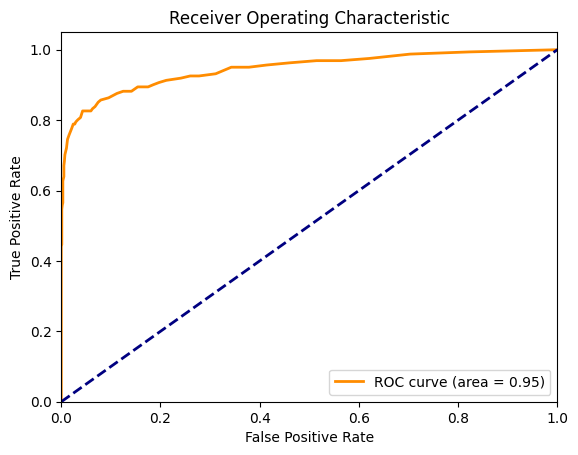

Feature ranking:
1. embedding 30 (0.077843)
2. embedding 21 (0.062669)
3. embedding 33 (0.058290)
4. embedding 6 (0.052252)
5. embedding 25 (0.051678)
6. embedding 20 (0.049586)
7. embedding 19 (0.046059)
8. embedding 0 (0.045006)
9. embedding 35 (0.036734)
10. embedding 14 (0.032481)
11. embedding 24 (0.029370)
12. embedding 37 (0.025072)
13. embedding 13 (0.024491)
14. embedding 17 (0.024172)
15. embedding 36 (0.020877)
16. embedding 7 (0.020157)
17. embedding 15 (0.019372)
18. embedding 9 (0.017998)
19. embedding 1 (0.017579)
20. embedding 18 (0.017530)
21. embedding 28 (0.017508)
22. embedding 12 (0.017315)
23. embedding 3 (0.016562)
24. embedding 27 (0.015913)
25. embedding 4 (0.015187)
26. embedding 2 (0.014971)
27. embedding 16 (0.014847)
28. embedding 10 (0.014041)
29. embedding 34 (0.014033)
30. embedding 22 (0.013703)
31. embedding 8 (0.012815)
32. embedding 31 (0.012140)
33. embedding 32 (0.012067)
34. embedding 5 (0.011849)
35. embedding 39 (0.011628)
36. embedding 29 (0.01

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np



# Select embedding columns as features. This assumes embedding column names are like 'embed_0', 'embed_1', ..., 'embed_39'
X = df.loc[:, df.columns.str.startswith('embed_')]
y = df['type'].apply(lambda x: 1 if x == 'spam' else 0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]  # probabilities for ROC curve

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. embedding %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


We notice that embeddings are slightly better predictors than tf-idf values we used before.

##Sentence Transformers: Computation of Embeddings

* Mechanism: Sentence-transformers modify the pre-trained BERT or other transformer models to produce meaningful sentence embeddings. It uses siamese and triplet network structures to derive semantically meaningful sentence embeddings that can be compared using cosine similarity.
* Training: It typically involves fine-tuning a transformer model on a dataset of sentence pairs with some similarity measure. The goal is to train embeddings such that similar sentences are close in vector space, and dissimilar sentences are far apart.

###Advantages and Disadvantages

**Doc2Vec:**

* Advantages:
** Good at capturing semantic meaning of longer texts.
** Does not require labeled data, as it uses unsupervised learning.

* Disadvantages:
** Inferior in capturing nuances compared to more advanced models like BERT.
** Requires careful hyperparameter tuning and significant training data to perform well.

**Sentence-Transformers**:

* Advantages:
** Produces state-of-the-art embeddings that are highly effective for many NLP tasks.
** Can leverage pre-trained transformer models which have been trained on vast amounts of data.
* Disadvantages:
** Computationally expensive, requiring powerful hardware (GPUs) for fine-tuning and inference.
** Sometimes overfitting can occur on smaller or less diverse datasets.

Models in sentence-transformers have fixed embedding sizes determined by their architecture. For example, models based on BERT typically produce embeddings of size 768, whereas smaller models like `all-MiniLM-L6-v2` produce embeddings of size 384.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/sms_spam.csv')

In [ ]:
%pip install -U sentence-transformers

In [ ]:
# !pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer

# Load a pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings and expand into separate columns
hf_embeddings = [model.encode(text) for text in df['text']]
df_hf_embeddings = pd.DataFrame(hf_embeddings, columns=[f'hf_embed_{i}' for i in range(len(hf_embeddings[0]))])
df = pd.concat([df, df_hf_embeddings], axis=1)

# Check the dataframe
print(df.head())


In [ ]:
df

### Reduce dimensionality
Sometimes you want to reduce the dimensionality of the embedding vector. In our case, let's say that we want to reduce from 384 dimensions to 40 dimensions. The basic approach is to apply dimensionality reduction techniques like PCA after generating embeddings.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/sms_spam.csv')

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

# Load a pre-trained model from sentence-transformers
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for all texts
hf_embeddings = [model.encode(text) for text in df['text']]

# Convert list of embeddings into a DataFrame
embeddings_df = pd.DataFrame(hf_embeddings)

# Initialize PCA to reduce to 40 dimensions
pca = PCA(n_components=40)
pca_result = pca.fit_transform(embeddings_df.values)

# Convert the PCA result into a DataFrame and set appropriate column names
df_pca_embeddings = pd.DataFrame(pca_result, columns=[f'pca_embed_{i}' for i in range(40)])

# Drop any existing PCA embedding columns first to avoid duplication
df = df.drop(columns=[col for col in df.columns if col.startswith('pca_embed_')], errors='ignore')

# Concatenate the original DataFrame with the PCA embeddings DataFrame
df = pd.concat([df, df_pca_embeddings], axis=1)

# Check the new DataFrame structure
print(df.head())


## Prediction with Sentence-Transformers

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np


# Assuming 'df' is the DataFrame and the target variable 'type' is encoded as 0 for 'ham' and 1 for 'spam'
# Select embedding columns as features. This assumes embedding column names are like 'embed_0', 'embed_1', ..., 'embed_39'
X = df.loc[:, df.columns.str.startswith('pca_embed_')]
y = df['type'].apply(lambda x: 1 if x == 'spam' else 0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]  # probabilities for ROC curve

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. embedding %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Your Turn
Read the `imdb.csv` file and predict the sentiment based on the embeddings of the review of the movie.

##Semantic Search
Semantic search is an approach that aims to understand the meaning behind a search query, instead of just matching keywords, in order to return more relevant results. We can use  embeddings, which are vector representations of underlying text that capture their meaning, to represent the meaning of a search query. In this exercise, we will perform a semantic search using embeddings.


### Read the PDF text
* Read the PDF document `docAI.pdf`.
* Split the text into sentences and store in a dataframe.
* Clean and preprocess the text.


In [7]:
%pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 2.2 MB/s eta 0:00:00


### Choice 1: Read the pdf locally

In [9]:
import pandas as pd
import numpy as np
from PyPDF2 import PdfReader
import re

# Read the PDF file
reader = PdfReader("docAI.pdf")

text = ""
for page in reader.pages:
    text += page.extract_text() + " "

# Split the text into sentences
sentences = re.split(r'\.\s+', text)

# Clean and preprocess the text
df = pd.DataFrame({'text': sentences})
df['clean_text'] = df['text'].str.lower()
df['clean_text'] = df['clean_text'].str.replace('[^a-z\s]', '', regex=True)
df['clean_text'] = df['clean_text'].str.replace('\s+', ' ', regex=True)
df['sentence_id'] = np.arange(len(df))


###Choice 2: Read from GitHub

In [17]:
import requests
from PyPDF2 import PdfReader
from io import BytesIO

# URL to the raw PDF file on GitHub
url = 'https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/docAI.pdf'

# Use requests to get the content of the PDF file
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Use BytesIO to convert the bytes response to a file-like object
    pdf_file = BytesIO(response.content)

    # Now you can use PdfReader to read the file
    reader = PdfReader(pdf_file)

    # Initialize a variable to hold all extracted text
    full_text = ""

    # Iterate over each page in the PDF file
    for page in reader.pages:
        text = page.extract_text()
        if text:  # Check if text was successfully extracted
            full_text += text + "\n"  # Append the text of each page

    text = full_text

else:
    print("Failed to download the file. Status code:", response.status_code)

###Split text into sentences and clean

In [18]:
# Split the text into sentences
sentences = re.split(r'\.\s+', text)

# Clean and preprocess the text
df = pd.DataFrame({'text': sentences})
df['clean_text'] = df['text'].str.lower()
df['clean_text'] = df['clean_text'].str.replace('[^a-z\s]', '', regex=True)
df['clean_text'] = df['clean_text'].str.replace('\s+', ' ', regex=True)
df['sentence_id'] = np.arange(len(df))

In [12]:
df

,text,clean_text,sentence_id
0,"2/24/23, 12:45 PM How generative AI & ChatGPT ...",pm how generative ai chatgpt will change busi...,0
1,DOWNLOADS\nArticle (5 pages)\nn the spirit of...,downloads article pages n the spirit of this a...,1
2,Our prompt to the system:\nWrite the opening p...,our prompt to the system write the opening par...,2
3,"ChatGPT’s response:\n\n2/24/23, 12:45 PM How g...",chatgpts response pm how generative ai chatgpt...,3
4,"This technology, which allows for the creation...",this technology which allows for the creation ...,4
5,By enabling the automation of many\ntasks that...,by enabling the automation of many tasks that ...,5
6,"As such, businesses that are able to e ectivel...",as such businesses that are able to eectively ...,6
7,Not perfect but overwhelmingly impressive,not perfect but overwhelmingly impressive,7
8,For us and many executives we’ve spoken to rec...,for us and many executives weve spoken to rece...,8
9,"In the  rst  ve days of its release, more than...",in the rst ve days of its release more than a ...,9


###Creating Sentence Embeddings with Doc2Vec

In [21]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize

# Tokenizing and tagging
tagged_data = [TaggedDocument(words=word_tokenize(doc), tags=[str(i)]) for i, doc in enumerate(df['clean_text'])]

# Training a Doc2Vec model
model = Doc2Vec(vector_size=100, min_count=2, epochs=40)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Saving embeddings
df['doc2vec_embedding'] = [model.infer_vector(word_tokenize(row['clean_text'])) for index, row in df.iterrows()]


In [ ]:
df

###Semantic Search Functionality
We will use cosine similarity to find the top 5 closest sentences

In [24]:
def find_top_5_similar_sentences(df, query, model):
    query_embedding = model.infer_vector(word_tokenize(query.lower()))
    embeddings_matrix = np.vstack(df['doc2vec_embedding'])
    similarities = cosine_similarity([query_embedding], embeddings_matrix)
    top_5_indices = np.argsort(similarities[0])[::-1][:5]
    return df.iloc[top_5_indices]['text']

In [25]:
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity  # Import cosine_similarity

# Set display options
pd.set_option('display.max_colwidth', None)  # Ensure no truncation
pd.set_option('display.max_rows', None)  # Display any number of rows

query = "computing power and ChatGPT"
top_5_sentences = find_top_5_similar_sentences(df, query, model)
for sentence in top_5_sentences:
    print(sentence)
    print()


For us and many executives we’ve spoken to recently, entering one
prompt into ChatGPT, developed by OpenAI, was all it took to see the
power of generative AI

Filters are not yet e ective enough to catch inappropriate content

For example, GPT 3.5, the
foundation model underlying ChatGPT, has also been used to translate
2/24/23, 12:45 PM How generative AI & ChatGPT  will change business | McKinsey
https://www .mckinsey .com/capabilities/quantumblack/our-insights/generative-ai-is-here-how-tools-like-chatgpt-could-change-your-business#/ 3/9text, and scientists used an earlier version of GPT to create novel
protein sequences

Its nascency requires
executives to proceed with an abundance of caution

Pushing further into human realms
More than a decade ago, we wrote an article in which we sorted
economic activity into three buckets—production, transactions, and
interactions—and examined the extent to which technology had made
inroads into each



### Creating Sentence Embeddings with Sentence Transformer

In [27]:
from sentence_transformers import SentenceTransformer

# Load the model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Create embeddings
df['sbert_embedding'] = [sbert_model.encode(text) for text in df['clean_text']]


ModuleNotFoundError: No module named 'sentence_transformers'

In [ ]:
df['clean_text']

###Semantic Search Functionality

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def semantic_search(query, embeddings, top_k=5):
    query_embedding = sbert_model.encode([query])
    cos_similarities = cosine_similarity(query_embedding, embeddings)[0]
    top_k_indices = np.argsort(cos_similarities)[::-1][:top_k]
    return df.iloc[top_k_indices]['clean_text']



In [ ]:
# Set display options
pd.set_option('display.max_colwidth', None)  # Ensure no truncation
pd.set_option('display.max_rows', None)  # Display any number of rows
query = "chatGPT will change businesses"
top_sentences = semantic_search(query, np.array(list(df['sbert_embedding'])))
for sentence in top_sentences:
    print(sentence)
    print()



Semantic search is a promising new technology that has the potential to revolutionize the way we search for information. As semantic search technology continues to develop, we can expect to see even more benefits in the future.



#YOUR TURN
1.	Read the document `Machine_stops.pdf` and implement semantic search over it.